## Data Loading, Visualization and Transformations

100%|██████████| 170M/170M [00:12<00:00, 13.6MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


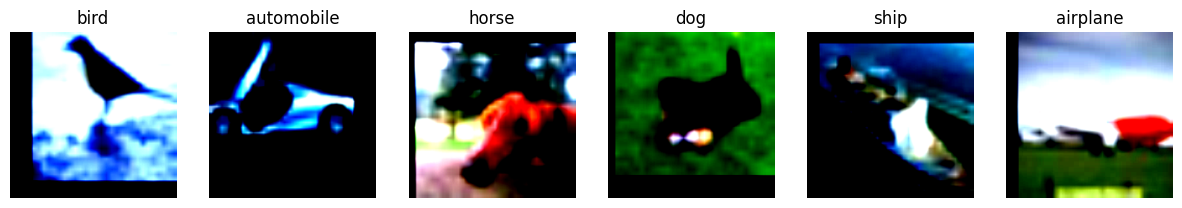

In [1]:
# Importing necessary libraries for model training, evaluation, and visualization
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import pandas as pd
import os
from tqdm import tqdm
from torch.utils.data import ConcatDataset


# Setting device to use GPU if available, otherwise using CPU
# This is helping to speed up training if a compatible GPU is present
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True  # Optimizing performance for GPU

# Making sure the directory for saving models exists
os.makedirs("models", exist_ok=True)

# Defining transformations for models needing 224x224 input size (e.g., MobileNet, EfficientNet, ResNet)
transform_224 = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  # Randomly cropping the image to 32x32 with padding
    transforms.RandomHorizontalFlip(),  # Randomly flipping the image horizontally
    transforms.Resize((224, 224)),  # Resizing to 224x224 as required by certain models
    transforms.ToTensor(),  # Converting the image to a tensor
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),  # Normalizing with mean and std
])

# Defining transformations for models needing 64x64 input size (e.g., CustomCNN)
transform_64 = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  # Randomly cropping the image to 32x32 with padding
    transforms.RandomHorizontalFlip(),  # Randomly flipping the image horizontally
    transforms.Resize((64, 64)),  # Resizing to 64x64 for faster training
    transforms.ToTensor(),  # Converting the image to a tensor
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),  # Normalizing with mean and std
])

# Loading CIFAR-10 dataset for training and testing with respective transformations
train_dataset_224 = datasets.CIFAR10(root='./data', train=True, transform=transform_224, download=True)
test_dataset_224 = datasets.CIFAR10(root='./data', train=False, transform=transform_224, download=True)

train_dataset_64 = datasets.CIFAR10(root='./data', train=True, transform=transform_64, download=True)
test_dataset_64 = datasets.CIFAR10(root='./data', train=False, transform=transform_64, download=True)

# Splitting training data into train and validation sets (80% train, 20% validation)
train_size = int(0.8 * len(train_dataset_224))
val_size = len(train_dataset_224) - train_size
train_set_224, val_set_224 = random_split(train_dataset_224, [train_size, val_size])
train_set_64, val_set_64 = random_split(train_dataset_64, [train_size, val_size])

# Setting up data loaders for training, validation, and testing
batch_size = 128
train_loader_224 = DataLoader(train_set_224, batch_size=batch_size, shuffle=True)
val_loader_224 = DataLoader(val_set_224, batch_size=batch_size, shuffle=False)
test_loader_224 = DataLoader(test_dataset_224, batch_size=batch_size, shuffle=False)

train_loader_64 = DataLoader(train_set_64, batch_size=batch_size, shuffle=True)
val_loader_64 = DataLoader(val_set_64, batch_size=batch_size, shuffle=False)
test_loader_64 = DataLoader(test_dataset_64, batch_size=batch_size, shuffle=False)

# Function for visualizing some images from the CIFAR-10 dataset
def visualize_cifar10_data(loader, classes):
    data_iter = iter(loader)
    images, labels = next(data_iter)
    fig, axes = plt.subplots(1, 6, figsize=(15, 5))
    for idx in range(6):
        axes[idx].imshow(images[idx].permute(1, 2, 0))  # Changing dimensions for plotting
        axes[idx].set_title(classes[labels[idx]])
        axes[idx].axis('off')
    plt.show()

cifar10_classes = train_dataset_224.classes
visualize_cifar10_data(train_loader_224, cifar10_classes)

### Custom CNN baseline architecture

In [2]:
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)

        # Fully connected layers
        self._calculate_fc_input()
        self.fc1 = nn.Linear(self.fc_input_size, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)

    def _calculate_fc_input(self):
        # Dummy input to calculate the size of the flattened tensor
        dummy_input = torch.zeros(1, 3, 64, 64)  # Assuming input size (3x64x64)
        x = self.pool(nn.ReLU()(self.conv1(dummy_input)))
        x = self.pool(nn.ReLU()(self.conv2(x)))
        x = self.pool(nn.ReLU()(self.conv3(x)))
        self.fc_input_size = x.numel()

    def forward(self, x):
        x = self.pool(nn.ReLU()(self.conv1(x)))
        x = self.pool(nn.ReLU()(self.conv2(x)))
        x = self.pool(nn.ReLU()(self.conv3(x)))
        x = x.view(-1, self.fc_input_size)  # Dynamically flatten
        x = nn.ReLU()(self.fc1(x))
        x = self.dropout(x)
        x = nn.ReLU()(self.fc2(x))
        return self.fc3(x)



## Other Pre-defined CNN Architectures (ResNet18, MobileNetV2, EfficientNetB0)

In [3]:
# Loading predefined models and modifying the final layer to match CIFAR-10 classes
resnet18 = models.resnet18(pretrained=False)
resnet18.fc = nn.Linear(resnet18.fc.in_features, 10)

mobilenet = models.mobilenet_v2(pretrained=False)
mobilenet.classifier[1] = nn.Linear(mobilenet.classifier[1].in_features, 10)

efficientnet = models.efficientnet_b0(pretrained=False)
efficientnet.classifier[1] = nn.Linear(efficientnet.classifier[1].in_features, 10)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


## Training, Hyper-parameter Tuning and Testing


Starting tuning for CustomCNN

Testing Hyperparameters: {'optimizer': <class 'torch.optim.adam.Adam'>, 'lr': 0.001, 'weight_decay': 0.0}


Training Epoch 1/10: 100%|██████████| 313/313 [00:26<00:00, 11.80it/s]


Epoch [1/10] - Train Loss: 1.6808, Train Acc: 0.3787, Val Loss: 1.4452, Val Acc: 0.4673


Training Epoch 2/10: 100%|██████████| 313/313 [00:24<00:00, 12.79it/s]


Epoch [2/10] - Train Loss: 1.3491, Train Acc: 0.5068, Val Loss: 1.2003, Val Acc: 0.5643


Training Epoch 3/10: 100%|██████████| 313/313 [00:24<00:00, 12.88it/s]


Epoch [3/10] - Train Loss: 1.1573, Train Acc: 0.5844, Val Loss: 1.1027, Val Acc: 0.6131


Training Epoch 4/10: 100%|██████████| 313/313 [00:24<00:00, 12.96it/s]


Epoch [4/10] - Train Loss: 1.0420, Train Acc: 0.6288, Val Loss: 0.9519, Val Acc: 0.6692


Training Epoch 5/10: 100%|██████████| 313/313 [00:23<00:00, 13.05it/s]


Epoch [5/10] - Train Loss: 0.9638, Train Acc: 0.6584, Val Loss: 0.9053, Val Acc: 0.6846


Training Epoch 6/10: 100%|██████████| 313/313 [00:23<00:00, 13.07it/s]


Epoch [6/10] - Train Loss: 0.9133, Train Acc: 0.6795, Val Loss: 0.8433, Val Acc: 0.7088


Training Epoch 7/10: 100%|██████████| 313/313 [00:23<00:00, 13.08it/s]


Epoch [7/10] - Train Loss: 0.8769, Train Acc: 0.6894, Val Loss: 0.8150, Val Acc: 0.7137


Training Epoch 8/10: 100%|██████████| 313/313 [00:24<00:00, 13.02it/s]


Epoch [8/10] - Train Loss: 0.8346, Train Acc: 0.7054, Val Loss: 0.8059, Val Acc: 0.7196


Training Epoch 9/10: 100%|██████████| 313/313 [00:24<00:00, 12.96it/s]


Epoch [9/10] - Train Loss: 0.8081, Train Acc: 0.7161, Val Loss: 0.7852, Val Acc: 0.7259


Training Epoch 10/10: 100%|██████████| 313/313 [00:24<00:00, 12.93it/s]


Epoch [10/10] - Train Loss: 0.7737, Train Acc: 0.7293, Val Loss: 0.7677, Val Acc: 0.7375


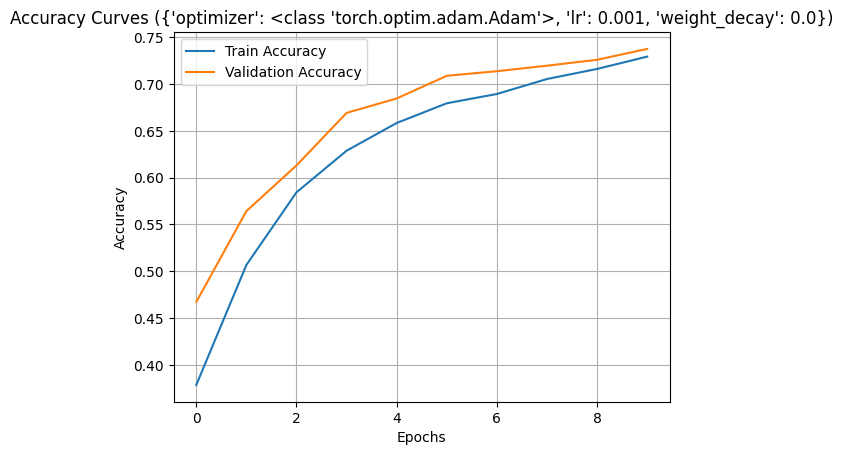

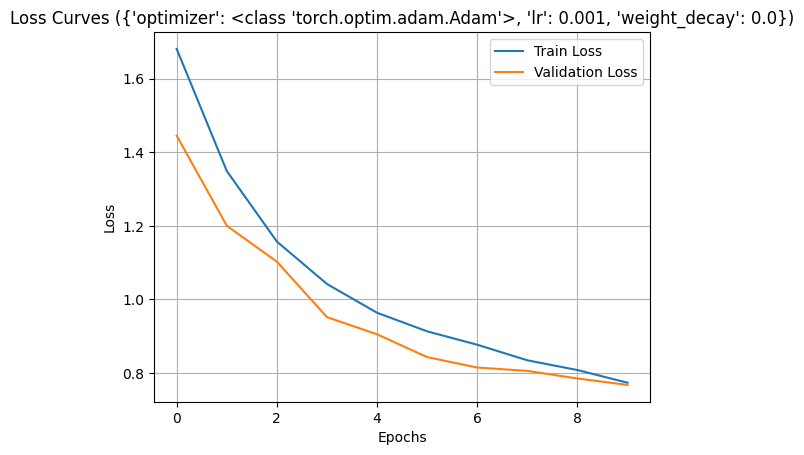


Testing Hyperparameters: {'optimizer': <class 'torch.optim.adam.Adam'>, 'lr': 0.01, 'weight_decay': 0.0001}


Training Epoch 1/10: 100%|██████████| 313/313 [00:24<00:00, 12.89it/s]


Epoch [1/10] - Train Loss: 2.2008, Train Acc: 0.2100, Val Loss: 2.1963, Val Acc: 0.1781


Training Epoch 2/10: 100%|██████████| 313/313 [00:24<00:00, 12.92it/s]


Epoch [2/10] - Train Loss: 1.9566, Train Acc: 0.2498, Val Loss: 1.8321, Val Acc: 0.3134


Training Epoch 3/10: 100%|██████████| 313/313 [00:24<00:00, 12.99it/s]


Epoch [3/10] - Train Loss: 1.8379, Train Acc: 0.3007, Val Loss: 1.7611, Val Acc: 0.3294


Training Epoch 4/10: 100%|██████████| 313/313 [00:24<00:00, 12.93it/s]


Epoch [4/10] - Train Loss: 1.7719, Train Acc: 0.3231, Val Loss: 1.7576, Val Acc: 0.3242


Training Epoch 5/10: 100%|██████████| 313/313 [00:24<00:00, 12.97it/s]


Epoch [5/10] - Train Loss: 1.7338, Train Acc: 0.3433, Val Loss: 1.8115, Val Acc: 0.3356


Training Epoch 6/10: 100%|██████████| 313/313 [00:24<00:00, 12.95it/s]


Epoch [6/10] - Train Loss: 1.7106, Train Acc: 0.3551, Val Loss: 1.6711, Val Acc: 0.3729


Training Epoch 7/10: 100%|██████████| 313/313 [00:24<00:00, 12.93it/s]


Epoch [7/10] - Train Loss: 1.6692, Train Acc: 0.3719, Val Loss: 1.7434, Val Acc: 0.3549


Training Epoch 8/10: 100%|██████████| 313/313 [00:24<00:00, 12.84it/s]


Epoch [8/10] - Train Loss: 1.6610, Train Acc: 0.3796, Val Loss: 1.5897, Val Acc: 0.4158


Training Epoch 9/10: 100%|██████████| 313/313 [00:24<00:00, 12.88it/s]


Epoch [9/10] - Train Loss: 1.6417, Train Acc: 0.3888, Val Loss: 1.5659, Val Acc: 0.4145


Training Epoch 10/10: 100%|██████████| 313/313 [00:24<00:00, 12.85it/s]


Epoch [10/10] - Train Loss: 1.7110, Train Acc: 0.3642, Val Loss: 1.7305, Val Acc: 0.3545


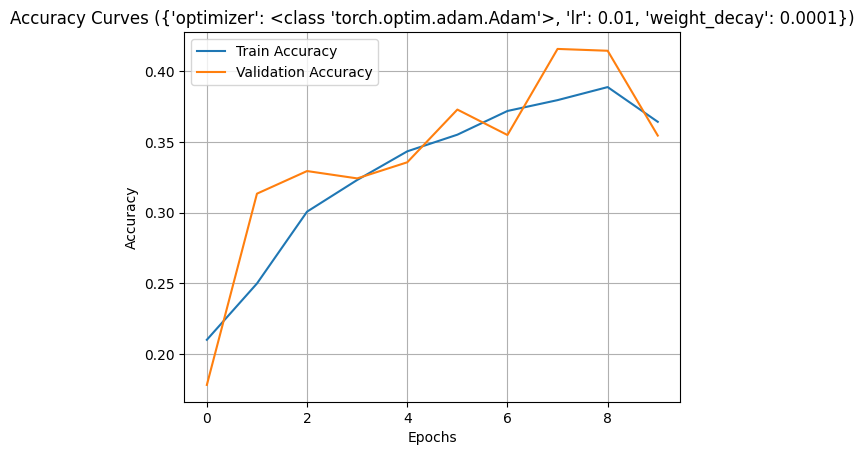

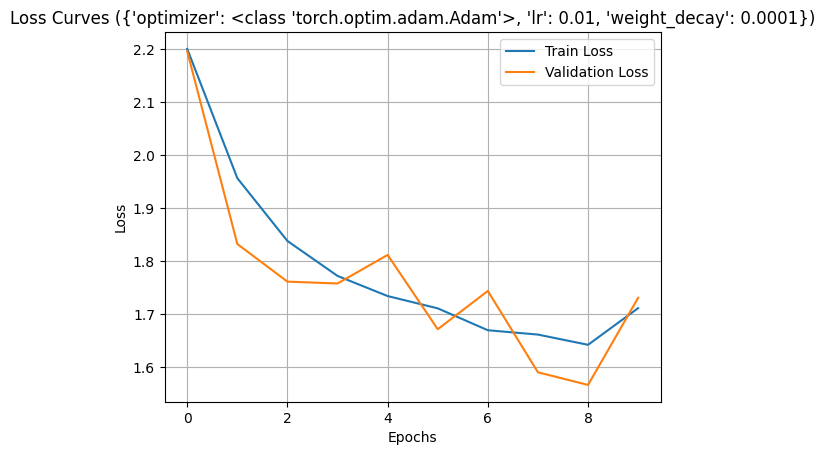


Testing Hyperparameters: {'optimizer': <class 'torch.optim.sgd.SGD'>, 'lr': 0.01, 'weight_decay': 0.0}


Training Epoch 1/10: 100%|██████████| 313/313 [00:24<00:00, 12.91it/s]


Epoch [1/10] - Train Loss: 1.6065, Train Acc: 0.3992, Val Loss: 1.5287, Val Acc: 0.4321


Training Epoch 2/10: 100%|██████████| 313/313 [00:24<00:00, 12.95it/s]


Epoch [2/10] - Train Loss: 1.5514, Train Acc: 0.4196, Val Loss: 1.5251, Val Acc: 0.4385


Training Epoch 3/10: 100%|██████████| 313/313 [00:24<00:00, 12.94it/s]


Epoch [3/10] - Train Loss: 1.5362, Train Acc: 0.4254, Val Loss: 1.5006, Val Acc: 0.4486


Training Epoch 4/10: 100%|██████████| 313/313 [00:24<00:00, 12.94it/s]


Epoch [4/10] - Train Loss: 1.5230, Train Acc: 0.4312, Val Loss: 1.4817, Val Acc: 0.4580


Training Epoch 5/10: 100%|██████████| 313/313 [00:24<00:00, 12.93it/s]


Epoch [5/10] - Train Loss: 1.5158, Train Acc: 0.4341, Val Loss: 1.4825, Val Acc: 0.4599


Training Epoch 6/10: 100%|██████████| 313/313 [00:24<00:00, 12.94it/s]


Epoch [6/10] - Train Loss: 1.5052, Train Acc: 0.4366, Val Loss: 1.4881, Val Acc: 0.4590


Training Epoch 7/10: 100%|██████████| 313/313 [00:24<00:00, 12.97it/s]


Epoch [7/10] - Train Loss: 1.4905, Train Acc: 0.4417, Val Loss: 1.4730, Val Acc: 0.4595


Training Epoch 8/10: 100%|██████████| 313/313 [00:24<00:00, 12.88it/s]


Epoch [8/10] - Train Loss: 1.4885, Train Acc: 0.4440, Val Loss: 1.4603, Val Acc: 0.4610


Training Epoch 9/10: 100%|██████████| 313/313 [00:24<00:00, 12.93it/s]


Epoch [9/10] - Train Loss: 1.4835, Train Acc: 0.4465, Val Loss: 1.4537, Val Acc: 0.4623


Training Epoch 10/10: 100%|██████████| 313/313 [00:24<00:00, 12.89it/s]


Epoch [10/10] - Train Loss: 1.4763, Train Acc: 0.4489, Val Loss: 1.4526, Val Acc: 0.4614


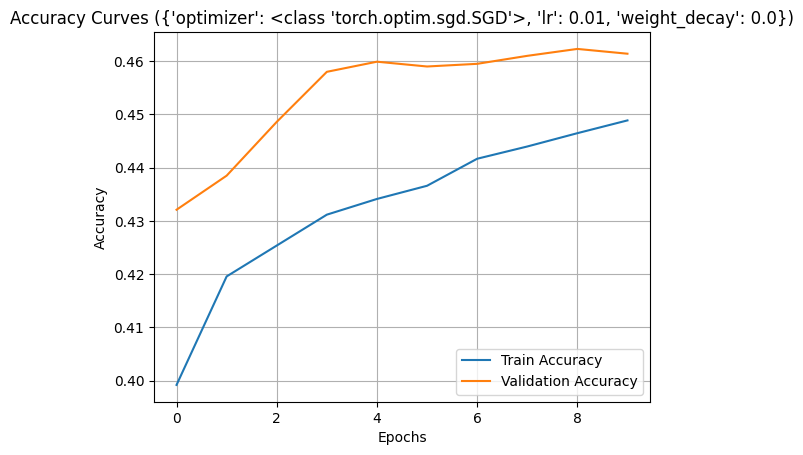

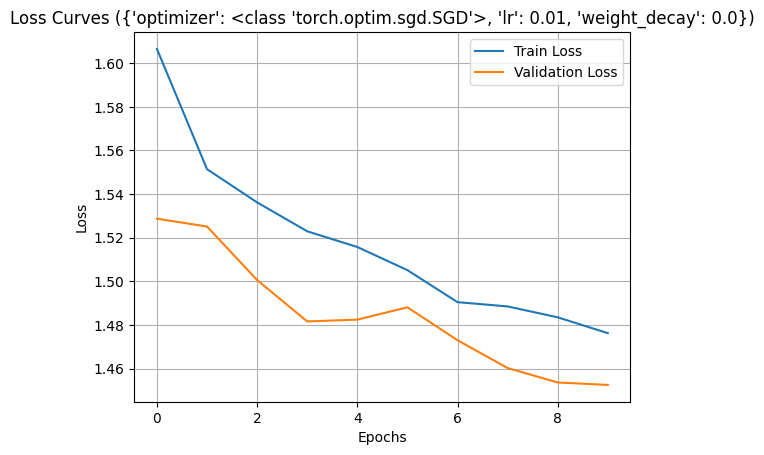


Testing Hyperparameters: {'optimizer': <class 'torch.optim.sgd.SGD'>, 'lr': 0.001, 'weight_decay': 0.0001}


Training Epoch 1/10: 100%|██████████| 313/313 [00:24<00:00, 12.90it/s]


Epoch [1/10] - Train Loss: 1.4737, Train Acc: 0.4516, Val Loss: 1.4432, Val Acc: 0.4728


Training Epoch 2/10: 100%|██████████| 313/313 [00:24<00:00, 12.96it/s]


Epoch [2/10] - Train Loss: 1.4706, Train Acc: 0.4544, Val Loss: 1.4455, Val Acc: 0.4697


Training Epoch 3/10: 100%|██████████| 313/313 [00:23<00:00, 13.06it/s]


Epoch [3/10] - Train Loss: 1.4719, Train Acc: 0.4495, Val Loss: 1.4411, Val Acc: 0.4729


Training Epoch 4/10: 100%|██████████| 313/313 [00:23<00:00, 13.06it/s]


Epoch [4/10] - Train Loss: 1.4627, Train Acc: 0.4520, Val Loss: 1.4340, Val Acc: 0.4745


Training Epoch 5/10: 100%|██████████| 313/313 [00:23<00:00, 13.05it/s]


Epoch [5/10] - Train Loss: 1.4605, Train Acc: 0.4551, Val Loss: 1.4422, Val Acc: 0.4675


Training Epoch 6/10: 100%|██████████| 313/313 [00:23<00:00, 13.05it/s]


Epoch [6/10] - Train Loss: 1.4627, Train Acc: 0.4550, Val Loss: 1.4409, Val Acc: 0.4648


Training Epoch 7/10: 100%|██████████| 313/313 [00:24<00:00, 13.02it/s]


Epoch [7/10] - Train Loss: 1.4666, Train Acc: 0.4538, Val Loss: 1.4373, Val Acc: 0.4715


Training Epoch 8/10: 100%|██████████| 313/313 [00:24<00:00, 13.02it/s]


Epoch [8/10] - Train Loss: 1.4641, Train Acc: 0.4524, Val Loss: 1.4353, Val Acc: 0.4744


Training Epoch 9/10: 100%|██████████| 313/313 [00:23<00:00, 13.10it/s]


Epoch [9/10] - Train Loss: 1.4631, Train Acc: 0.4543, Val Loss: 1.4321, Val Acc: 0.4770


Training Epoch 10/10: 100%|██████████| 313/313 [00:23<00:00, 13.11it/s]


Epoch [10/10] - Train Loss: 1.4686, Train Acc: 0.4500, Val Loss: 1.4444, Val Acc: 0.4678


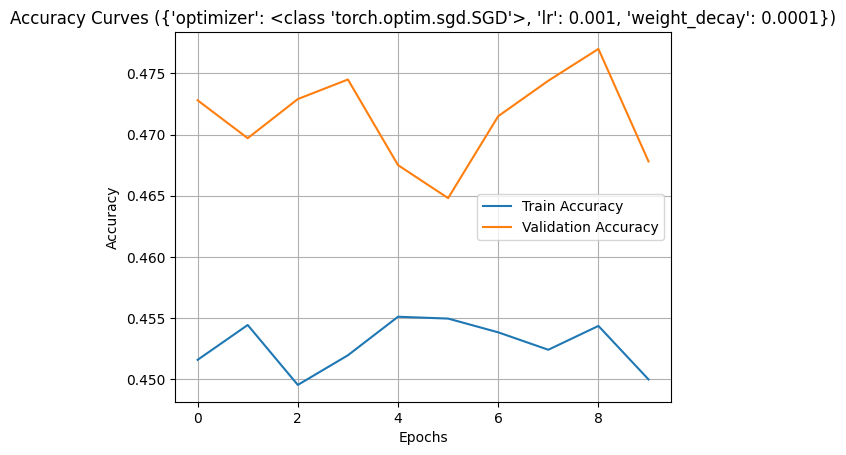

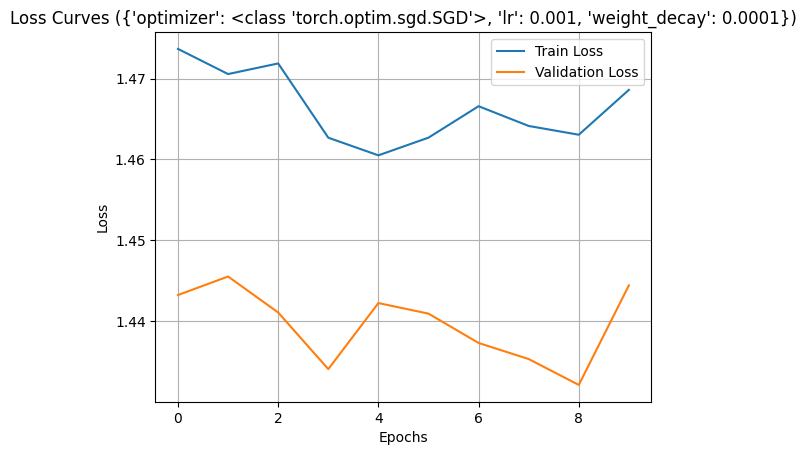


Retraining CustomCNN with best parameters on full training data...


Training Epoch 1/10: 100%|██████████| 391/391 [00:30<00:00, 12.80it/s]


Epoch [1/10] - Train Loss: 1.4395, Train Acc: 0.4670, Val Loss: 1.3227, Val Acc: 0.5217


Training Epoch 2/10: 100%|██████████| 391/391 [00:30<00:00, 12.81it/s]


Epoch [2/10] - Train Loss: 1.3340, Train Acc: 0.5107, Val Loss: 1.2214, Val Acc: 0.5555


Training Epoch 3/10: 100%|██████████| 391/391 [00:30<00:00, 12.81it/s]


Epoch [3/10] - Train Loss: 1.2439, Train Acc: 0.5497, Val Loss: 1.1409, Val Acc: 0.5909


Training Epoch 4/10: 100%|██████████| 391/391 [00:30<00:00, 12.74it/s]


Epoch [4/10] - Train Loss: 1.1797, Train Acc: 0.5743, Val Loss: 1.1084, Val Acc: 0.6078


Training Epoch 5/10: 100%|██████████| 391/391 [00:30<00:00, 12.73it/s]


Epoch [5/10] - Train Loss: 1.1288, Train Acc: 0.5948, Val Loss: 1.0403, Val Acc: 0.6304


Training Epoch 6/10: 100%|██████████| 391/391 [00:30<00:00, 12.69it/s]


Epoch [6/10] - Train Loss: 1.0865, Train Acc: 0.6119, Val Loss: 1.0004, Val Acc: 0.6412


Training Epoch 7/10: 100%|██████████| 391/391 [00:30<00:00, 12.70it/s]


Epoch [7/10] - Train Loss: 1.0440, Train Acc: 0.6261, Val Loss: 0.9614, Val Acc: 0.6598


Training Epoch 8/10: 100%|██████████| 391/391 [00:30<00:00, 12.73it/s]


Epoch [8/10] - Train Loss: 1.0208, Train Acc: 0.6352, Val Loss: 0.9417, Val Acc: 0.6723


Training Epoch 9/10: 100%|██████████| 391/391 [00:30<00:00, 12.64it/s]


Epoch [9/10] - Train Loss: 0.9917, Train Acc: 0.6490, Val Loss: 0.9091, Val Acc: 0.6780


Training Epoch 10/10: 100%|██████████| 391/391 [00:30<00:00, 12.71it/s]


Epoch [10/10] - Train Loss: 0.9688, Train Acc: 0.6548, Val Loss: 0.9021, Val Acc: 0.6853


<ipython-input-4-76da0df54b77>:140: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"models/best_tuned_{model.__class__.__name__}.pth"))


Highest Validation Accuracy for CustomCNN: 68.53%
Highest Testing Accuracy for CustomCNN: 73.74%

Starting tuning for ResNet18

Testing Hyperparameters: {'optimizer': <class 'torch.optim.adam.Adam'>, 'lr': 0.001, 'weight_decay': 0.0}


Training Epoch 1/10: 100%|██████████| 313/313 [01:21<00:00,  3.82it/s]


Epoch [1/10] - Train Loss: 1.5311, Train Acc: 0.4375, Val Loss: 1.4314, Val Acc: 0.4906


Training Epoch 2/10: 100%|██████████| 313/313 [01:20<00:00,  3.88it/s]


Epoch [2/10] - Train Loss: 1.0096, Train Acc: 0.6379, Val Loss: 0.9983, Val Acc: 0.6433


Training Epoch 3/10: 100%|██████████| 313/313 [01:20<00:00,  3.90it/s]


Epoch [3/10] - Train Loss: 0.8054, Train Acc: 0.7144, Val Loss: 0.8481, Val Acc: 0.6971


Training Epoch 4/10: 100%|██████████| 313/313 [01:20<00:00,  3.89it/s]


Epoch [4/10] - Train Loss: 0.6762, Train Acc: 0.7651, Val Loss: 0.7330, Val Acc: 0.7478


Training Epoch 5/10: 100%|██████████| 313/313 [01:20<00:00,  3.91it/s]


Epoch [5/10] - Train Loss: 0.5975, Train Acc: 0.7928, Val Loss: 0.6419, Val Acc: 0.7744


Training Epoch 6/10: 100%|██████████| 313/313 [01:16<00:00,  4.09it/s]


Epoch [6/10] - Train Loss: 0.5288, Train Acc: 0.8174, Val Loss: 0.6884, Val Acc: 0.7607


Training Epoch 7/10: 100%|██████████| 313/313 [01:16<00:00,  4.08it/s]


Epoch [7/10] - Train Loss: 0.4800, Train Acc: 0.8348, Val Loss: 0.5640, Val Acc: 0.8062


Training Epoch 8/10: 100%|██████████| 313/313 [01:16<00:00,  4.07it/s]


Epoch [8/10] - Train Loss: 0.4486, Train Acc: 0.8438, Val Loss: 0.5492, Val Acc: 0.8105


Training Epoch 9/10: 100%|██████████| 313/313 [01:16<00:00,  4.09it/s]


Epoch [9/10] - Train Loss: 0.3971, Train Acc: 0.8625, Val Loss: 0.6147, Val Acc: 0.7958


Training Epoch 10/10: 100%|██████████| 313/313 [01:16<00:00,  4.07it/s]


Epoch [10/10] - Train Loss: 0.3716, Train Acc: 0.8706, Val Loss: 0.5094, Val Acc: 0.8271


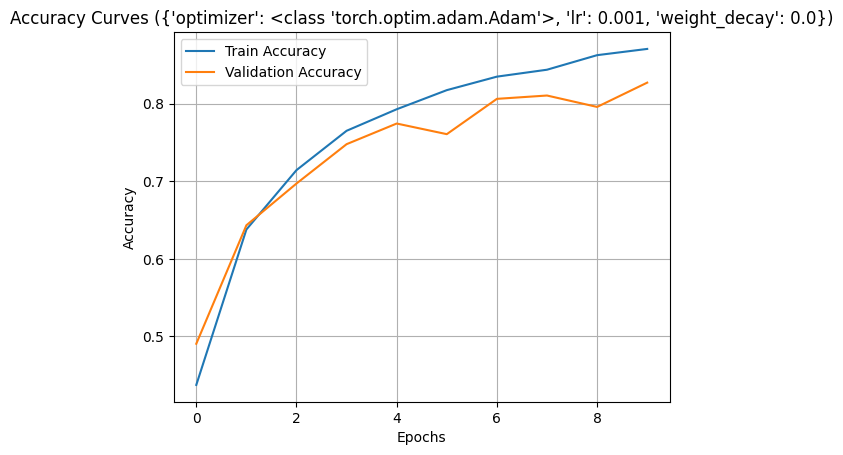

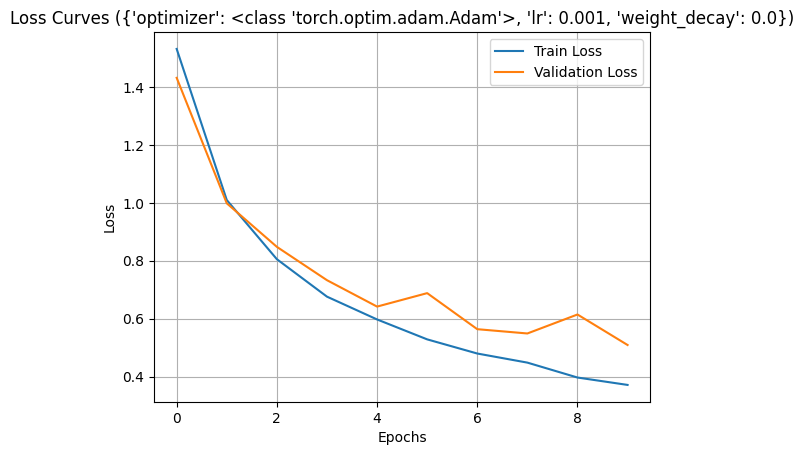


Testing Hyperparameters: {'optimizer': <class 'torch.optim.adam.Adam'>, 'lr': 0.01, 'weight_decay': 0.0001}


Training Epoch 1/10: 100%|██████████| 313/313 [01:16<00:00,  4.08it/s]


Epoch [1/10] - Train Loss: 1.3056, Train Acc: 0.5445, Val Loss: 1.4981, Val Acc: 0.4855


Training Epoch 2/10: 100%|██████████| 313/313 [01:16<00:00,  4.09it/s]


Epoch [2/10] - Train Loss: 1.0298, Train Acc: 0.6385, Val Loss: 1.5295, Val Acc: 0.5223


Training Epoch 3/10: 100%|██████████| 313/313 [01:16<00:00,  4.10it/s]


Epoch [3/10] - Train Loss: 0.8914, Train Acc: 0.6865, Val Loss: 1.2383, Val Acc: 0.5766


Training Epoch 4/10: 100%|██████████| 313/313 [01:16<00:00,  4.09it/s]


Epoch [4/10] - Train Loss: 0.8224, Train Acc: 0.7140, Val Loss: 1.0758, Val Acc: 0.6407


Training Epoch 5/10: 100%|██████████| 313/313 [01:16<00:00,  4.10it/s]


Epoch [5/10] - Train Loss: 0.7607, Train Acc: 0.7336, Val Loss: 1.0091, Val Acc: 0.6472


Training Epoch 6/10: 100%|██████████| 313/313 [01:16<00:00,  4.09it/s]


Epoch [6/10] - Train Loss: 0.7260, Train Acc: 0.7475, Val Loss: 0.9914, Val Acc: 0.6548


Training Epoch 7/10: 100%|██████████| 313/313 [01:17<00:00,  4.06it/s]


Epoch [7/10] - Train Loss: 0.7028, Train Acc: 0.7589, Val Loss: 0.8913, Val Acc: 0.6834


Training Epoch 8/10: 100%|██████████| 313/313 [01:16<00:00,  4.08it/s]


Epoch [8/10] - Train Loss: 0.6799, Train Acc: 0.7652, Val Loss: 0.7335, Val Acc: 0.7415


Training Epoch 9/10: 100%|██████████| 313/313 [01:16<00:00,  4.07it/s]


Epoch [9/10] - Train Loss: 0.6558, Train Acc: 0.7721, Val Loss: 0.8482, Val Acc: 0.7101


Training Epoch 10/10: 100%|██████████| 313/313 [01:17<00:00,  4.06it/s]


Epoch [10/10] - Train Loss: 0.6482, Train Acc: 0.7778, Val Loss: 0.8467, Val Acc: 0.7059


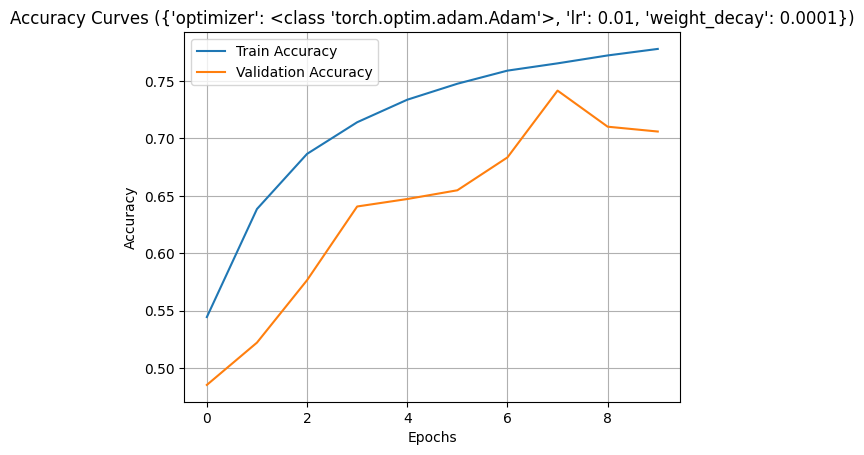

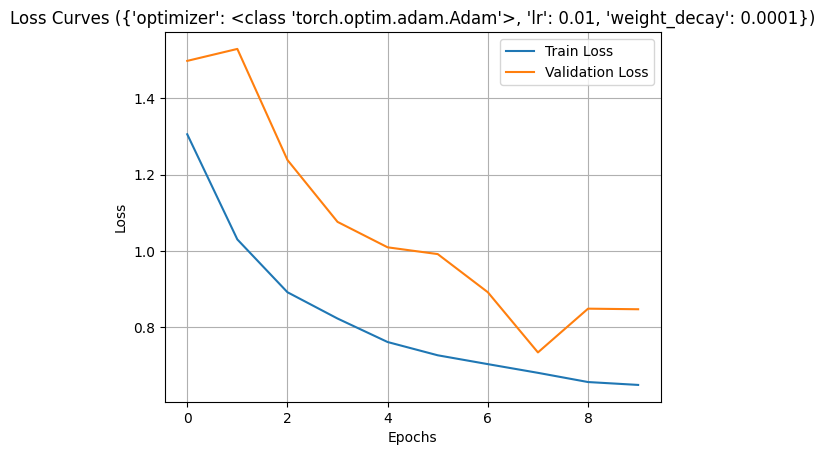


Testing Hyperparameters: {'optimizer': <class 'torch.optim.sgd.SGD'>, 'lr': 0.01, 'weight_decay': 0.0}


Training Epoch 1/10: 100%|██████████| 313/313 [01:16<00:00,  4.09it/s]


Epoch [1/10] - Train Loss: 0.5788, Train Acc: 0.8022, Val Loss: 0.6010, Val Acc: 0.7906


Training Epoch 2/10: 100%|██████████| 313/313 [01:16<00:00,  4.10it/s]


Epoch [2/10] - Train Loss: 0.5562, Train Acc: 0.8083, Val Loss: 0.5870, Val Acc: 0.7951


Training Epoch 3/10: 100%|██████████| 313/313 [01:16<00:00,  4.10it/s]


Epoch [3/10] - Train Loss: 0.5383, Train Acc: 0.8147, Val Loss: 0.5768, Val Acc: 0.8011


Training Epoch 4/10: 100%|██████████| 313/313 [01:16<00:00,  4.10it/s]


Epoch [4/10] - Train Loss: 0.5284, Train Acc: 0.8174, Val Loss: 0.5599, Val Acc: 0.8046


Training Epoch 5/10: 100%|██████████| 313/313 [01:15<00:00,  4.12it/s]


Epoch [5/10] - Train Loss: 0.5226, Train Acc: 0.8197, Val Loss: 0.5592, Val Acc: 0.8022


Training Epoch 6/10: 100%|██████████| 313/313 [01:16<00:00,  4.10it/s]


Epoch [6/10] - Train Loss: 0.5174, Train Acc: 0.8205, Val Loss: 0.5567, Val Acc: 0.8038


Training Epoch 7/10: 100%|██████████| 313/313 [01:16<00:00,  4.10it/s]


Epoch [7/10] - Train Loss: 0.5132, Train Acc: 0.8230, Val Loss: 0.5487, Val Acc: 0.8065


Training Epoch 8/10: 100%|██████████| 313/313 [01:15<00:00,  4.12it/s]


Epoch [8/10] - Train Loss: 0.5085, Train Acc: 0.8244, Val Loss: 0.5420, Val Acc: 0.8092


Training Epoch 9/10: 100%|██████████| 313/313 [01:15<00:00,  4.12it/s]


Epoch [9/10] - Train Loss: 0.5029, Train Acc: 0.8262, Val Loss: 0.5418, Val Acc: 0.8091


Training Epoch 10/10: 100%|██████████| 313/313 [01:16<00:00,  4.10it/s]


Epoch [10/10] - Train Loss: 0.4991, Train Acc: 0.8283, Val Loss: 0.5408, Val Acc: 0.8088


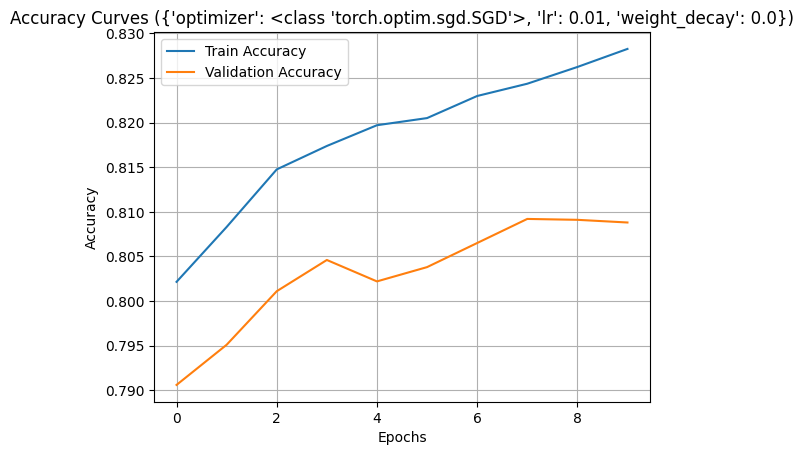

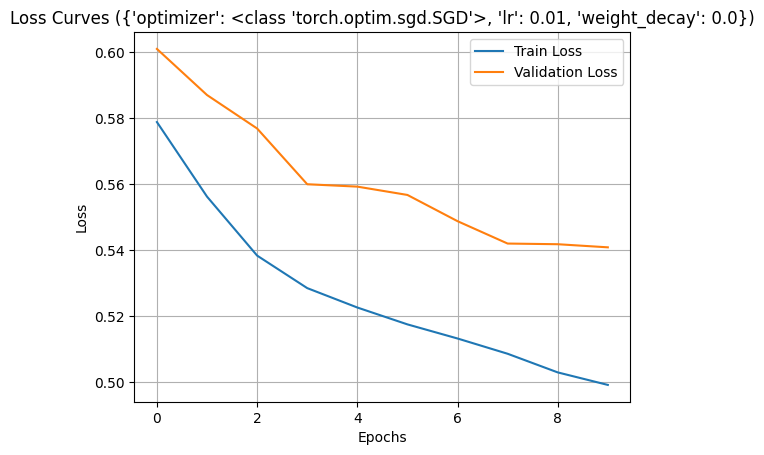


Testing Hyperparameters: {'optimizer': <class 'torch.optim.sgd.SGD'>, 'lr': 0.001, 'weight_decay': 0.0001}


Training Epoch 1/10: 100%|██████████| 313/313 [01:16<00:00,  4.10it/s]


Epoch [1/10] - Train Loss: 0.4983, Train Acc: 0.8282, Val Loss: 0.5496, Val Acc: 0.8091


Training Epoch 2/10: 100%|██████████| 313/313 [01:16<00:00,  4.11it/s]


Epoch [2/10] - Train Loss: 0.4952, Train Acc: 0.8286, Val Loss: 0.5413, Val Acc: 0.8078


Training Epoch 3/10: 100%|██████████| 313/313 [01:16<00:00,  4.11it/s]


Epoch [3/10] - Train Loss: 0.4924, Train Acc: 0.8297, Val Loss: 0.5398, Val Acc: 0.8128


Training Epoch 4/10: 100%|██████████| 313/313 [01:16<00:00,  4.10it/s]


Epoch [4/10] - Train Loss: 0.4943, Train Acc: 0.8300, Val Loss: 0.5418, Val Acc: 0.8080


Training Epoch 5/10: 100%|██████████| 313/313 [01:16<00:00,  4.11it/s]


Epoch [5/10] - Train Loss: 0.4975, Train Acc: 0.8290, Val Loss: 0.5456, Val Acc: 0.8077


Training Epoch 6/10: 100%|██████████| 313/313 [01:16<00:00,  4.11it/s]


Epoch [6/10] - Train Loss: 0.4981, Train Acc: 0.8266, Val Loss: 0.5387, Val Acc: 0.8084


Training Epoch 7/10: 100%|██████████| 313/313 [01:16<00:00,  4.09it/s]


Epoch [7/10] - Train Loss: 0.4978, Train Acc: 0.8289, Val Loss: 0.5372, Val Acc: 0.8094


Training Epoch 8/10: 100%|██████████| 313/313 [01:16<00:00,  4.10it/s]


Epoch [8/10] - Train Loss: 0.4985, Train Acc: 0.8271, Val Loss: 0.5387, Val Acc: 0.8085


Training Epoch 9/10: 100%|██████████| 313/313 [01:16<00:00,  4.11it/s]


Epoch [9/10] - Train Loss: 0.4979, Train Acc: 0.8285, Val Loss: 0.5401, Val Acc: 0.8098


Training Epoch 10/10: 100%|██████████| 313/313 [01:16<00:00,  4.10it/s]


Epoch [10/10] - Train Loss: 0.4979, Train Acc: 0.8272, Val Loss: 0.5310, Val Acc: 0.8112


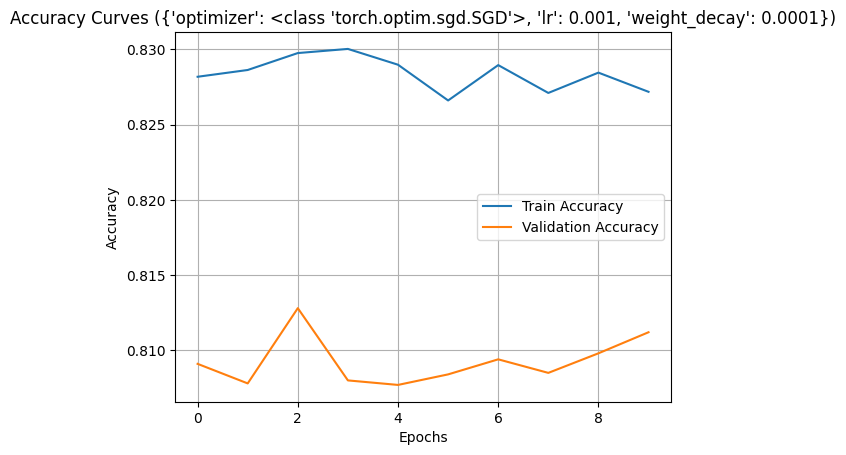

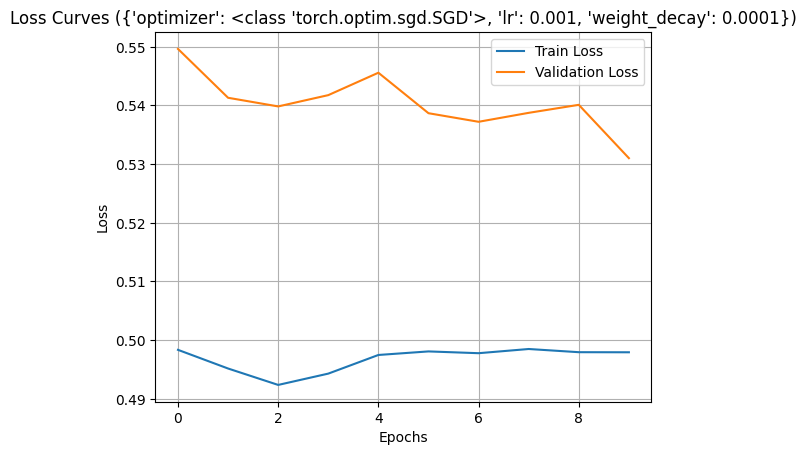


Retraining ResNet18 with best parameters on full training data...


Training Epoch 1/10: 100%|██████████| 391/391 [01:36<00:00,  4.05it/s]


Epoch [1/10] - Train Loss: 0.4826, Train Acc: 0.8310, Val Loss: 0.4750, Val Acc: 0.8317


Training Epoch 2/10: 100%|██████████| 391/391 [01:36<00:00,  4.07it/s]


Epoch [2/10] - Train Loss: 0.4443, Train Acc: 0.8462, Val Loss: 0.4362, Val Acc: 0.8460


Training Epoch 3/10: 100%|██████████| 391/391 [01:36<00:00,  4.05it/s]


Epoch [3/10] - Train Loss: 0.4195, Train Acc: 0.8540, Val Loss: 0.4133, Val Acc: 0.8526


Training Epoch 4/10: 100%|██████████| 391/391 [01:36<00:00,  4.07it/s]


Epoch [4/10] - Train Loss: 0.4008, Train Acc: 0.8611, Val Loss: 0.4008, Val Acc: 0.8594


Training Epoch 5/10: 100%|██████████| 391/391 [01:36<00:00,  4.06it/s]


Epoch [5/10] - Train Loss: 0.3817, Train Acc: 0.8685, Val Loss: 0.3820, Val Acc: 0.8652


Training Epoch 6/10: 100%|██████████| 391/391 [01:36<00:00,  4.06it/s]


Epoch [6/10] - Train Loss: 0.3649, Train Acc: 0.8733, Val Loss: 0.3738, Val Acc: 0.8663


Training Epoch 7/10: 100%|██████████| 391/391 [01:36<00:00,  4.07it/s]


Epoch [7/10] - Train Loss: 0.3517, Train Acc: 0.8781, Val Loss: 0.3504, Val Acc: 0.8747


Training Epoch 8/10: 100%|██████████| 391/391 [01:36<00:00,  4.06it/s]


Epoch [8/10] - Train Loss: 0.3374, Train Acc: 0.8833, Val Loss: 0.3221, Val Acc: 0.8831


Training Epoch 9/10: 100%|██████████| 391/391 [01:36<00:00,  4.06it/s]


Epoch [9/10] - Train Loss: 0.3248, Train Acc: 0.8874, Val Loss: 0.3255, Val Acc: 0.8858


Training Epoch 10/10: 100%|██████████| 391/391 [01:36<00:00,  4.06it/s]


Epoch [10/10] - Train Loss: 0.3162, Train Acc: 0.8903, Val Loss: 0.3032, Val Acc: 0.8926
Highest Validation Accuracy for ResNet18: 89.26%
Highest Testing Accuracy for ResNet18: 82.17%

Starting tuning for MobileNetV2

Testing Hyperparameters: {'optimizer': <class 'torch.optim.adam.Adam'>, 'lr': 0.001, 'weight_decay': 0.0}


Training Epoch 1/10: 100%|██████████| 313/313 [01:34<00:00,  3.33it/s]


Epoch [1/10] - Train Loss: 1.5663, Train Acc: 0.4183, Val Loss: 1.3865, Val Acc: 0.5290


Training Epoch 2/10: 100%|██████████| 313/313 [01:33<00:00,  3.36it/s]


Epoch [2/10] - Train Loss: 1.1057, Train Acc: 0.6041, Val Loss: 1.2896, Val Acc: 0.5667


Training Epoch 3/10: 100%|██████████| 313/313 [01:32<00:00,  3.37it/s]


Epoch [3/10] - Train Loss: 0.8814, Train Acc: 0.6893, Val Loss: 0.9216, Val Acc: 0.6842


Training Epoch 4/10: 100%|██████████| 313/313 [01:32<00:00,  3.38it/s]


Epoch [4/10] - Train Loss: 0.7361, Train Acc: 0.7400, Val Loss: 0.8025, Val Acc: 0.7142


Training Epoch 5/10: 100%|██████████| 313/313 [01:32<00:00,  3.37it/s]


Epoch [5/10] - Train Loss: 0.6473, Train Acc: 0.7728, Val Loss: 0.7274, Val Acc: 0.7429


Training Epoch 6/10: 100%|██████████| 313/313 [01:33<00:00,  3.35it/s]


Epoch [6/10] - Train Loss: 0.5766, Train Acc: 0.8010, Val Loss: 0.6432, Val Acc: 0.7734


Training Epoch 7/10: 100%|██████████| 313/313 [01:32<00:00,  3.37it/s]


Epoch [7/10] - Train Loss: 0.5297, Train Acc: 0.8152, Val Loss: 0.5459, Val Acc: 0.8084


Training Epoch 8/10: 100%|██████████| 313/313 [01:32<00:00,  3.37it/s]


Epoch [8/10] - Train Loss: 0.4783, Train Acc: 0.8322, Val Loss: 0.5756, Val Acc: 0.8042


Training Epoch 9/10: 100%|██████████| 313/313 [01:33<00:00,  3.36it/s]


Epoch [9/10] - Train Loss: 0.4486, Train Acc: 0.8448, Val Loss: 0.5106, Val Acc: 0.8269


Training Epoch 10/10: 100%|██████████| 313/313 [01:32<00:00,  3.37it/s]


Epoch [10/10] - Train Loss: 0.4182, Train Acc: 0.8542, Val Loss: 0.4668, Val Acc: 0.8377


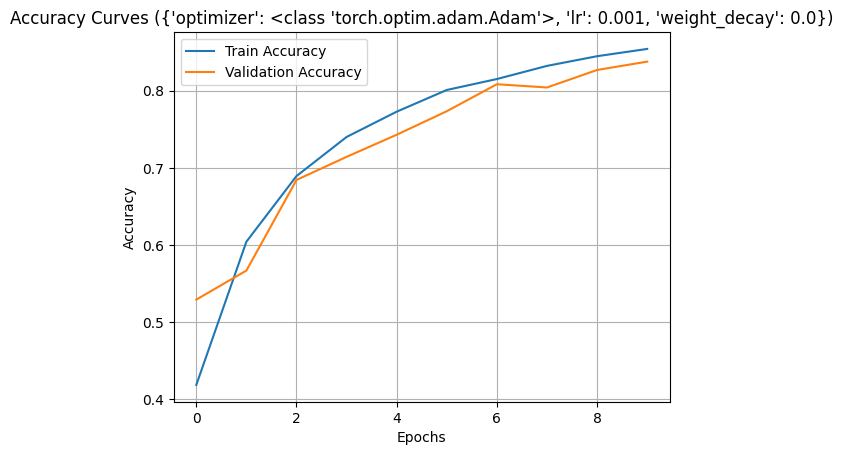

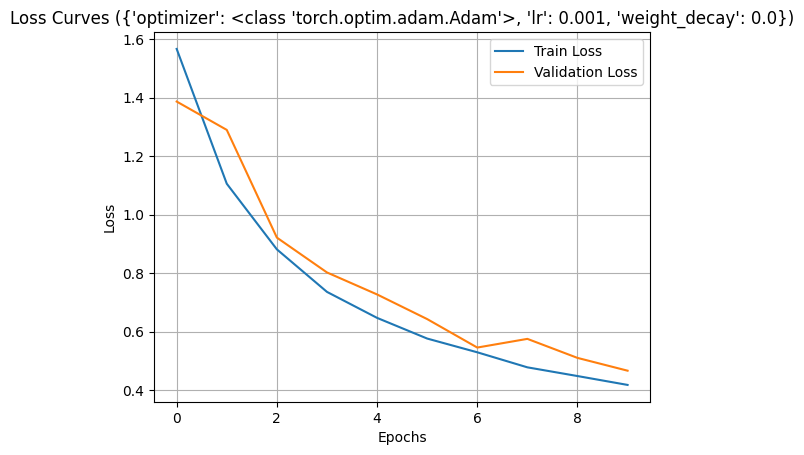


Testing Hyperparameters: {'optimizer': <class 'torch.optim.adam.Adam'>, 'lr': 0.01, 'weight_decay': 0.0001}


Training Epoch 1/10: 100%|██████████| 313/313 [01:33<00:00,  3.36it/s]


Epoch [1/10] - Train Loss: 1.3680, Train Acc: 0.5169, Val Loss: 1.3342, Val Acc: 0.5310


Training Epoch 2/10: 100%|██████████| 313/313 [01:32<00:00,  3.37it/s]


Epoch [2/10] - Train Loss: 1.0689, Train Acc: 0.6243, Val Loss: 1.2347, Val Acc: 0.5478


Training Epoch 3/10: 100%|██████████| 313/313 [01:33<00:00,  3.36it/s]


Epoch [3/10] - Train Loss: 0.9652, Train Acc: 0.6631, Val Loss: 1.1480, Val Acc: 0.6177


Training Epoch 4/10: 100%|██████████| 313/313 [01:33<00:00,  3.36it/s]


Epoch [4/10] - Train Loss: 0.9066, Train Acc: 0.6832, Val Loss: 1.1982, Val Acc: 0.5901


Training Epoch 5/10: 100%|██████████| 313/313 [01:33<00:00,  3.36it/s]


Epoch [5/10] - Train Loss: 0.8591, Train Acc: 0.7007, Val Loss: 0.9041, Val Acc: 0.6842


Training Epoch 6/10: 100%|██████████| 313/313 [01:32<00:00,  3.37it/s]


Epoch [6/10] - Train Loss: 0.8193, Train Acc: 0.7154, Val Loss: 0.9483, Val Acc: 0.6685


Training Epoch 7/10: 100%|██████████| 313/313 [01:33<00:00,  3.36it/s]


Epoch [7/10] - Train Loss: 0.7915, Train Acc: 0.7257, Val Loss: 0.8652, Val Acc: 0.6945


Training Epoch 8/10: 100%|██████████| 313/313 [01:33<00:00,  3.36it/s]


Epoch [8/10] - Train Loss: 0.7690, Train Acc: 0.7342, Val Loss: 0.9946, Val Acc: 0.6664


Training Epoch 9/10: 100%|██████████| 313/313 [01:32<00:00,  3.37it/s]


Epoch [9/10] - Train Loss: 0.7488, Train Acc: 0.7405, Val Loss: 1.0851, Val Acc: 0.6302


Training Epoch 10/10: 100%|██████████| 313/313 [01:33<00:00,  3.36it/s]


Epoch [10/10] - Train Loss: 0.7405, Train Acc: 0.7434, Val Loss: 0.8602, Val Acc: 0.6976


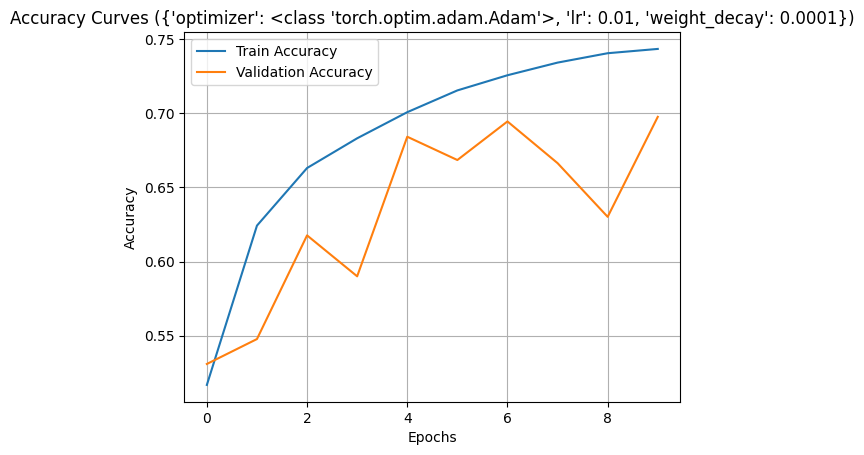

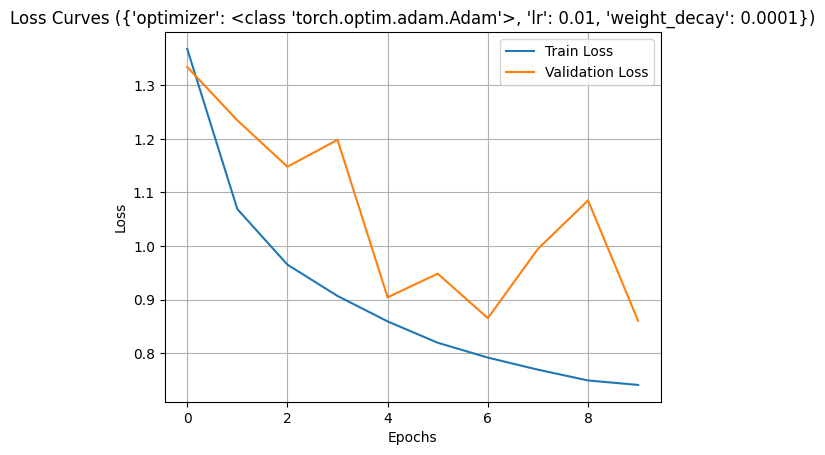


Testing Hyperparameters: {'optimizer': <class 'torch.optim.sgd.SGD'>, 'lr': 0.01, 'weight_decay': 0.0}


Training Epoch 1/10: 100%|██████████| 313/313 [01:33<00:00,  3.36it/s]


Epoch [1/10] - Train Loss: 0.6817, Train Acc: 0.7643, Val Loss: 0.6525, Val Acc: 0.7722


Training Epoch 2/10: 100%|██████████| 313/313 [01:32<00:00,  3.37it/s]


Epoch [2/10] - Train Loss: 0.6343, Train Acc: 0.7808, Val Loss: 0.6334, Val Acc: 0.7788


Training Epoch 3/10: 100%|██████████| 313/313 [01:33<00:00,  3.36it/s]


Epoch [3/10] - Train Loss: 0.6111, Train Acc: 0.7897, Val Loss: 0.6150, Val Acc: 0.7876


Training Epoch 4/10: 100%|██████████| 313/313 [01:33<00:00,  3.36it/s]


Epoch [4/10] - Train Loss: 0.5977, Train Acc: 0.7916, Val Loss: 0.6089, Val Acc: 0.7861


Training Epoch 5/10: 100%|██████████| 313/313 [01:33<00:00,  3.36it/s]


Epoch [5/10] - Train Loss: 0.5912, Train Acc: 0.7955, Val Loss: 0.5971, Val Acc: 0.7917


Training Epoch 6/10: 100%|██████████| 313/313 [01:33<00:00,  3.36it/s]


Epoch [6/10] - Train Loss: 0.5847, Train Acc: 0.7960, Val Loss: 0.5988, Val Acc: 0.7914


Training Epoch 7/10: 100%|██████████| 313/313 [01:33<00:00,  3.36it/s]


Epoch [7/10] - Train Loss: 0.5761, Train Acc: 0.7997, Val Loss: 0.5928, Val Acc: 0.7937


Training Epoch 8/10: 100%|██████████| 313/313 [01:32<00:00,  3.37it/s]


Epoch [8/10] - Train Loss: 0.5702, Train Acc: 0.8020, Val Loss: 0.5847, Val Acc: 0.7930


Training Epoch 9/10: 100%|██████████| 313/313 [01:32<00:00,  3.37it/s]


Epoch [9/10] - Train Loss: 0.5674, Train Acc: 0.8030, Val Loss: 0.5840, Val Acc: 0.7970


Training Epoch 10/10: 100%|██████████| 313/313 [01:32<00:00,  3.37it/s]


Epoch [10/10] - Train Loss: 0.5614, Train Acc: 0.8050, Val Loss: 0.5783, Val Acc: 0.7992


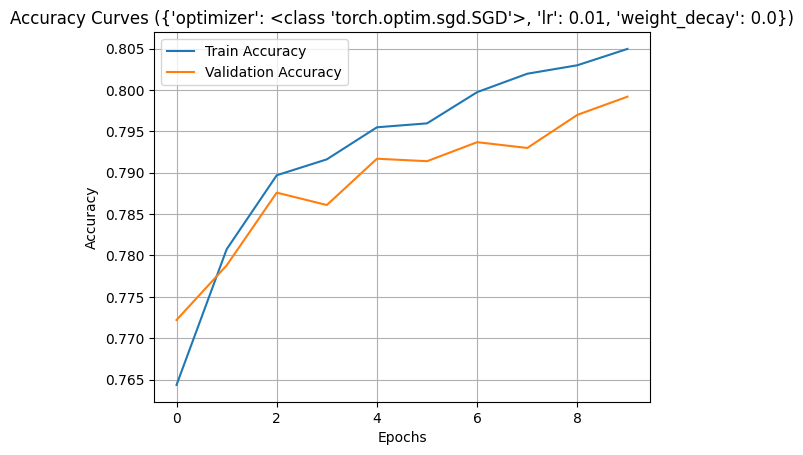

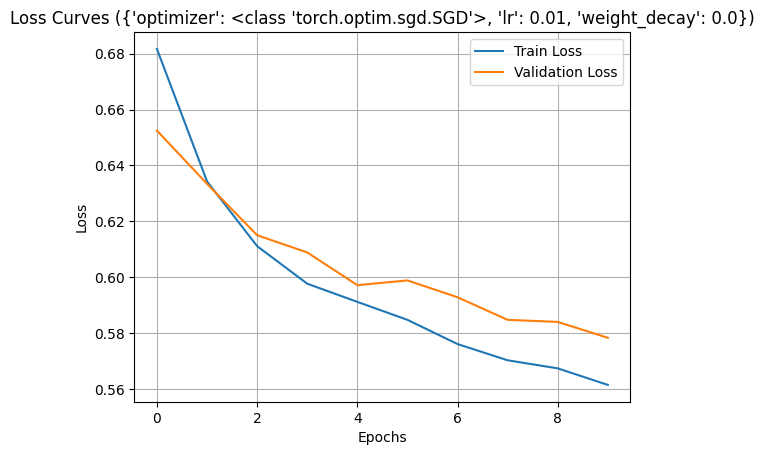


Testing Hyperparameters: {'optimizer': <class 'torch.optim.sgd.SGD'>, 'lr': 0.001, 'weight_decay': 0.0001}


Training Epoch 1/10: 100%|██████████| 313/313 [01:33<00:00,  3.36it/s]


Epoch [1/10] - Train Loss: 0.5628, Train Acc: 0.8034, Val Loss: 0.5763, Val Acc: 0.7989


Training Epoch 2/10: 100%|██████████| 313/313 [01:33<00:00,  3.37it/s]


Epoch [2/10] - Train Loss: 0.5573, Train Acc: 0.8069, Val Loss: 0.5807, Val Acc: 0.7984


Training Epoch 3/10: 100%|██████████| 313/313 [01:33<00:00,  3.35it/s]


Epoch [3/10] - Train Loss: 0.5621, Train Acc: 0.8050, Val Loss: 0.5725, Val Acc: 0.7989


Training Epoch 4/10: 100%|██████████| 313/313 [01:33<00:00,  3.36it/s]


Epoch [4/10] - Train Loss: 0.5563, Train Acc: 0.8073, Val Loss: 0.5812, Val Acc: 0.7983


Training Epoch 5/10: 100%|██████████| 313/313 [01:33<00:00,  3.36it/s]


Epoch [5/10] - Train Loss: 0.5622, Train Acc: 0.8049, Val Loss: 0.5759, Val Acc: 0.8014


Training Epoch 6/10: 100%|██████████| 313/313 [01:33<00:00,  3.35it/s]


Epoch [6/10] - Train Loss: 0.5586, Train Acc: 0.8064, Val Loss: 0.5780, Val Acc: 0.7999


Training Epoch 7/10: 100%|██████████| 313/313 [01:32<00:00,  3.37it/s]


Epoch [7/10] - Train Loss: 0.5598, Train Acc: 0.8042, Val Loss: 0.5729, Val Acc: 0.7982


Training Epoch 8/10: 100%|██████████| 313/313 [01:33<00:00,  3.35it/s]


Epoch [8/10] - Train Loss: 0.5621, Train Acc: 0.8043, Val Loss: 0.5779, Val Acc: 0.7987


Training Epoch 9/10: 100%|██████████| 313/313 [01:33<00:00,  3.35it/s]


Epoch [9/10] - Train Loss: 0.5567, Train Acc: 0.8068, Val Loss: 0.5753, Val Acc: 0.7971


Training Epoch 10/10: 100%|██████████| 313/313 [01:33<00:00,  3.35it/s]


Epoch [10/10] - Train Loss: 0.5570, Train Acc: 0.8050, Val Loss: 0.5777, Val Acc: 0.7978


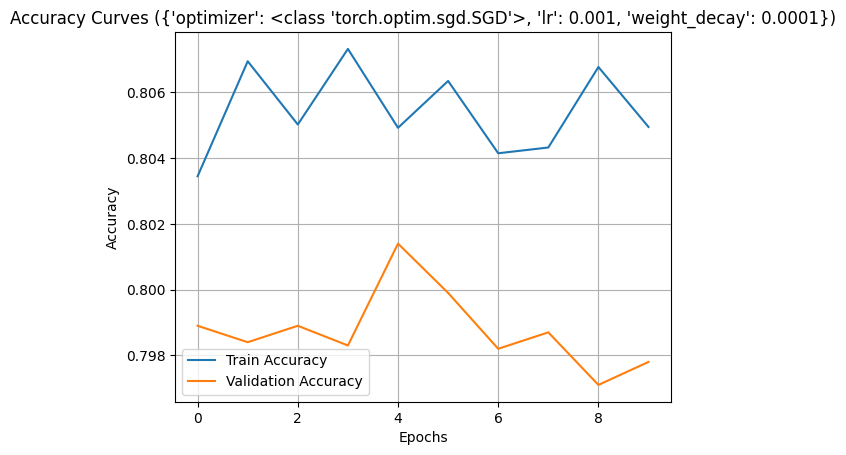

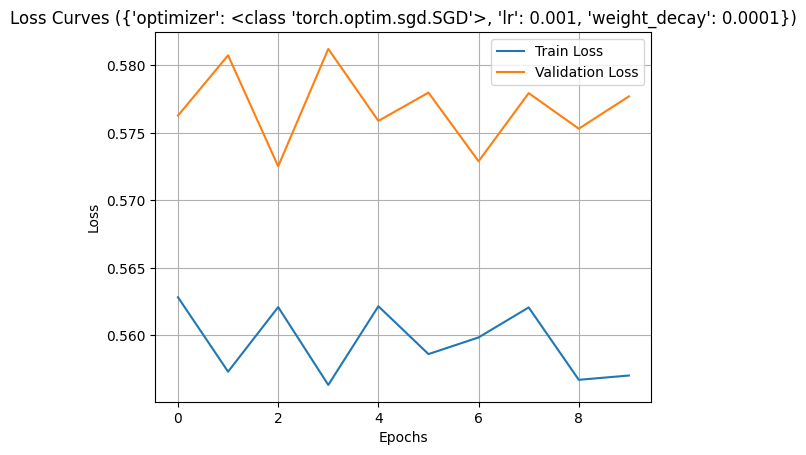


Retraining MobileNetV2 with best parameters on full training data...


Training Epoch 1/10: 100%|██████████| 391/391 [01:57<00:00,  3.32it/s]


Epoch [1/10] - Train Loss: 0.5511, Train Acc: 0.8088, Val Loss: 0.5172, Val Acc: 0.8195


Training Epoch 2/10: 100%|██████████| 391/391 [01:57<00:00,  3.34it/s]


Epoch [2/10] - Train Loss: 0.5062, Train Acc: 0.8233, Val Loss: 0.4890, Val Acc: 0.8256


Training Epoch 3/10: 100%|██████████| 391/391 [01:57<00:00,  3.33it/s]


Epoch [3/10] - Train Loss: 0.4872, Train Acc: 0.8310, Val Loss: 0.4723, Val Acc: 0.8330


Training Epoch 4/10: 100%|██████████| 391/391 [01:57<00:00,  3.33it/s]


Epoch [4/10] - Train Loss: 0.4661, Train Acc: 0.8386, Val Loss: 0.4443, Val Acc: 0.8470


Training Epoch 5/10: 100%|██████████| 391/391 [01:57<00:00,  3.33it/s]


Epoch [5/10] - Train Loss: 0.4488, Train Acc: 0.8435, Val Loss: 0.4202, Val Acc: 0.8509


Training Epoch 6/10: 100%|██████████| 391/391 [01:57<00:00,  3.34it/s]


Epoch [6/10] - Train Loss: 0.4328, Train Acc: 0.8504, Val Loss: 0.4234, Val Acc: 0.8532


Training Epoch 7/10: 100%|██████████| 391/391 [01:57<00:00,  3.33it/s]


Epoch [7/10] - Train Loss: 0.4209, Train Acc: 0.8534, Val Loss: 0.3984, Val Acc: 0.8625


Training Epoch 8/10: 100%|██████████| 391/391 [01:57<00:00,  3.33it/s]


Epoch [8/10] - Train Loss: 0.4079, Train Acc: 0.8591, Val Loss: 0.3973, Val Acc: 0.8639


Training Epoch 9/10: 100%|██████████| 391/391 [01:57<00:00,  3.33it/s]


Epoch [9/10] - Train Loss: 0.3927, Train Acc: 0.8634, Val Loss: 0.3674, Val Acc: 0.8708


Training Epoch 10/10: 100%|██████████| 391/391 [01:57<00:00,  3.32it/s]


Epoch [10/10] - Train Loss: 0.3837, Train Acc: 0.8664, Val Loss: 0.3577, Val Acc: 0.8729
Highest Validation Accuracy for MobileNetV2: 87.29%
Highest Testing Accuracy for MobileNetV2: 83.33%

Starting tuning for EfficientNetB0

Testing Hyperparameters: {'optimizer': <class 'torch.optim.adam.Adam'>, 'lr': 0.001, 'weight_decay': 0.0}


Training Epoch 1/10: 100%|██████████| 313/313 [01:42<00:00,  3.06it/s]


Epoch [1/10] - Train Loss: 1.6459, Train Acc: 0.3862, Val Loss: 1.3633, Val Acc: 0.5285


Training Epoch 2/10: 100%|██████████| 313/313 [01:40<00:00,  3.12it/s]


Epoch [2/10] - Train Loss: 1.0690, Train Acc: 0.6195, Val Loss: 0.8927, Val Acc: 0.6883


Training Epoch 3/10: 100%|██████████| 313/313 [01:40<00:00,  3.12it/s]


Epoch [3/10] - Train Loss: 0.7947, Train Acc: 0.7230, Val Loss: 0.7029, Val Acc: 0.7597


Training Epoch 4/10: 100%|██████████| 313/313 [01:40<00:00,  3.12it/s]


Epoch [4/10] - Train Loss: 0.6382, Train Acc: 0.7794, Val Loss: 0.6247, Val Acc: 0.7913


Training Epoch 5/10: 100%|██████████| 313/313 [01:39<00:00,  3.13it/s]


Epoch [5/10] - Train Loss: 0.5515, Train Acc: 0.8107, Val Loss: 0.5249, Val Acc: 0.8167


Training Epoch 6/10: 100%|██████████| 313/313 [01:40<00:00,  3.12it/s]


Epoch [6/10] - Train Loss: 0.4827, Train Acc: 0.8348, Val Loss: 0.4996, Val Acc: 0.8300


Training Epoch 7/10: 100%|██████████| 313/313 [01:40<00:00,  3.11it/s]


Epoch [7/10] - Train Loss: 0.4357, Train Acc: 0.8504, Val Loss: 0.4707, Val Acc: 0.8417


Training Epoch 8/10: 100%|██████████| 313/313 [01:40<00:00,  3.11it/s]


Epoch [8/10] - Train Loss: 0.3921, Train Acc: 0.8645, Val Loss: 0.4273, Val Acc: 0.8540


Training Epoch 9/10: 100%|██████████| 313/313 [01:40<00:00,  3.10it/s]


Epoch [9/10] - Train Loss: 0.3582, Train Acc: 0.8785, Val Loss: 0.4098, Val Acc: 0.8620


Training Epoch 10/10: 100%|██████████| 313/313 [01:41<00:00,  3.07it/s]


Epoch [10/10] - Train Loss: 0.3296, Train Acc: 0.8858, Val Loss: 0.4084, Val Acc: 0.8592


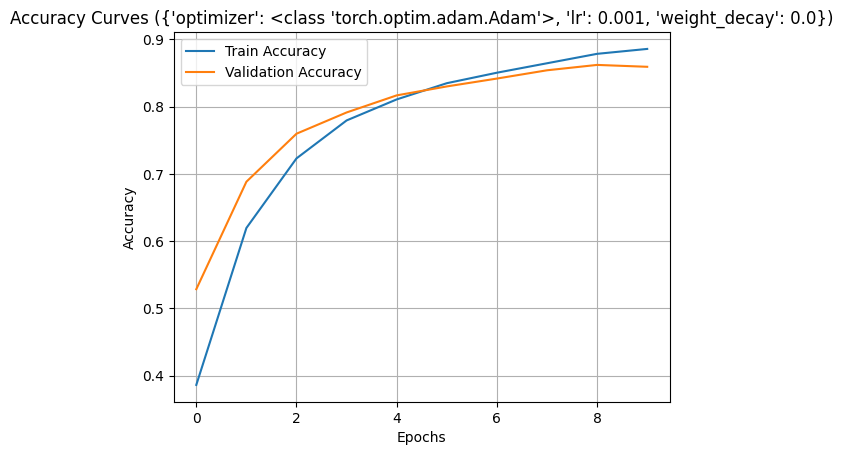

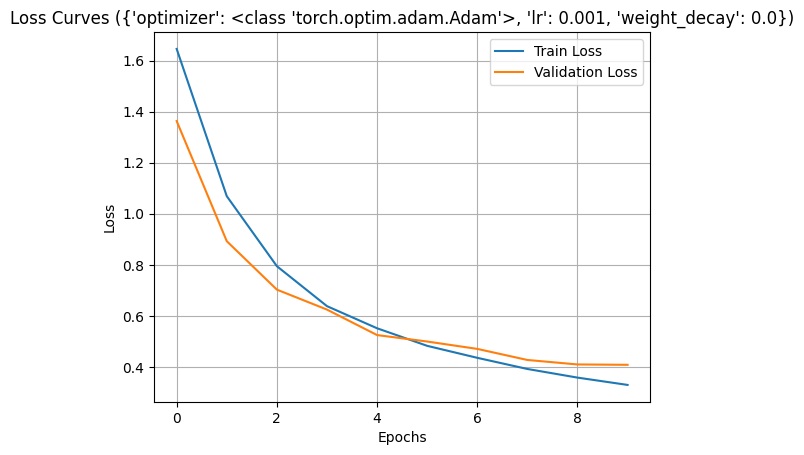


Testing Hyperparameters: {'optimizer': <class 'torch.optim.adam.Adam'>, 'lr': 0.01, 'weight_decay': 0.0001}


Training Epoch 1/10: 100%|██████████| 313/313 [01:41<00:00,  3.09it/s]


Epoch [1/10] - Train Loss: 1.2112, Train Acc: 0.5748, Val Loss: 1.1558, Val Acc: 0.6108


Training Epoch 2/10: 100%|██████████| 313/313 [01:41<00:00,  3.10it/s]


Epoch [2/10] - Train Loss: 0.8950, Train Acc: 0.6905, Val Loss: 1.1010, Val Acc: 0.6270


Training Epoch 3/10: 100%|██████████| 313/313 [01:41<00:00,  3.09it/s]


Epoch [3/10] - Train Loss: 0.8066, Train Acc: 0.7241, Val Loss: 0.9329, Val Acc: 0.6947


Training Epoch 4/10: 100%|██████████| 313/313 [01:41<00:00,  3.08it/s]


Epoch [4/10] - Train Loss: 0.7503, Train Acc: 0.7427, Val Loss: 0.8604, Val Acc: 0.7013


Training Epoch 5/10: 100%|██████████| 313/313 [01:41<00:00,  3.09it/s]


Epoch [5/10] - Train Loss: 0.7158, Train Acc: 0.7550, Val Loss: 1.1135, Val Acc: 0.6309


Training Epoch 6/10: 100%|██████████| 313/313 [01:41<00:00,  3.10it/s]


Epoch [6/10] - Train Loss: 0.6780, Train Acc: 0.7695, Val Loss: 0.7505, Val Acc: 0.7472


Training Epoch 7/10: 100%|██████████| 313/313 [01:40<00:00,  3.11it/s]


Epoch [7/10] - Train Loss: 0.6600, Train Acc: 0.7761, Val Loss: 0.8536, Val Acc: 0.7181


Training Epoch 8/10: 100%|██████████| 313/313 [01:40<00:00,  3.11it/s]


Epoch [8/10] - Train Loss: 0.6358, Train Acc: 0.7837, Val Loss: 0.7411, Val Acc: 0.7436


Training Epoch 9/10: 100%|██████████| 313/313 [01:41<00:00,  3.09it/s]


Epoch [9/10] - Train Loss: 0.6279, Train Acc: 0.7882, Val Loss: 0.7074, Val Acc: 0.7603


Training Epoch 10/10: 100%|██████████| 313/313 [01:41<00:00,  3.09it/s]


Epoch [10/10] - Train Loss: 0.6004, Train Acc: 0.7965, Val Loss: 0.9045, Val Acc: 0.7073


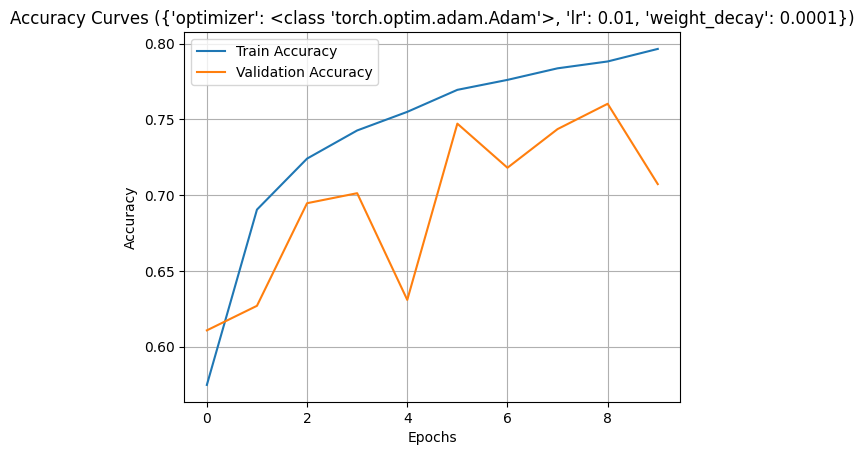

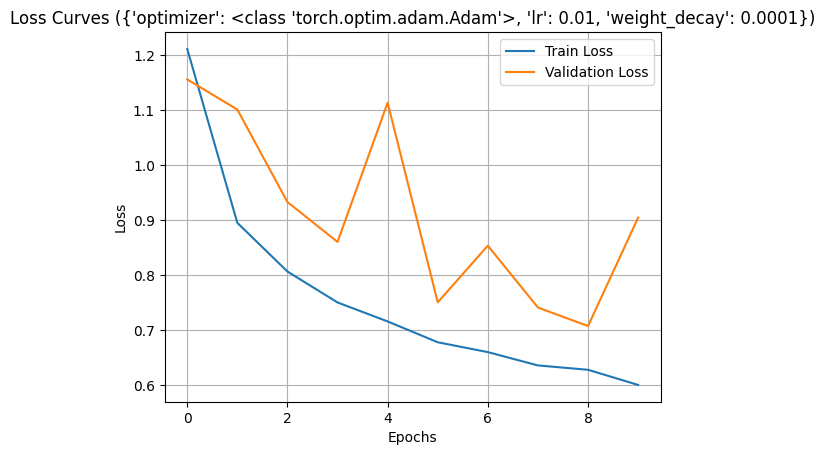


Testing Hyperparameters: {'optimizer': <class 'torch.optim.sgd.SGD'>, 'lr': 0.01, 'weight_decay': 0.0}


Training Epoch 1/10: 100%|██████████| 313/313 [01:39<00:00,  3.13it/s]


Epoch [1/10] - Train Loss: 0.5538, Train Acc: 0.8108, Val Loss: 0.5288, Val Acc: 0.8201


Training Epoch 2/10: 100%|██████████| 313/313 [01:40<00:00,  3.11it/s]


Epoch [2/10] - Train Loss: 0.5106, Train Acc: 0.8260, Val Loss: 0.5081, Val Acc: 0.8261


Training Epoch 3/10: 100%|██████████| 313/313 [01:36<00:00,  3.23it/s]


Epoch [3/10] - Train Loss: 0.4890, Train Acc: 0.8340, Val Loss: 0.4875, Val Acc: 0.8325


Training Epoch 4/10: 100%|██████████| 313/313 [01:40<00:00,  3.11it/s]


Epoch [4/10] - Train Loss: 0.4750, Train Acc: 0.8375, Val Loss: 0.4852, Val Acc: 0.8334


Training Epoch 5/10: 100%|██████████| 313/313 [01:41<00:00,  3.07it/s]


Epoch [5/10] - Train Loss: 0.4668, Train Acc: 0.8403, Val Loss: 0.4717, Val Acc: 0.8378


Training Epoch 6/10: 100%|██████████| 313/313 [01:40<00:00,  3.12it/s]


Epoch [6/10] - Train Loss: 0.4519, Train Acc: 0.8474, Val Loss: 0.4649, Val Acc: 0.8441


Training Epoch 7/10: 100%|██████████| 313/313 [01:40<00:00,  3.12it/s]


Epoch [7/10] - Train Loss: 0.4481, Train Acc: 0.8479, Val Loss: 0.4546, Val Acc: 0.8423


Training Epoch 8/10: 100%|██████████| 313/313 [01:41<00:00,  3.07it/s]


Epoch [8/10] - Train Loss: 0.4458, Train Acc: 0.8470, Val Loss: 0.4505, Val Acc: 0.8450


Training Epoch 9/10: 100%|██████████| 313/313 [01:40<00:00,  3.11it/s]


Epoch [9/10] - Train Loss: 0.4380, Train Acc: 0.8503, Val Loss: 0.4474, Val Acc: 0.8465


Training Epoch 10/10: 100%|██████████| 313/313 [01:41<00:00,  3.09it/s]


Epoch [10/10] - Train Loss: 0.4308, Train Acc: 0.8521, Val Loss: 0.4480, Val Acc: 0.8447


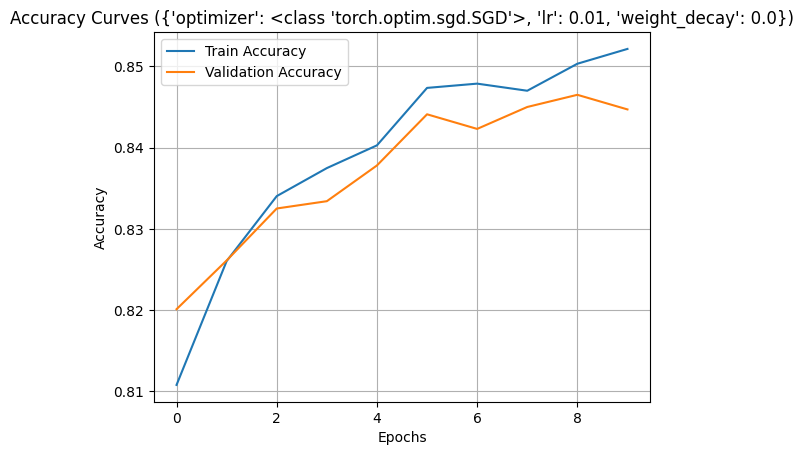

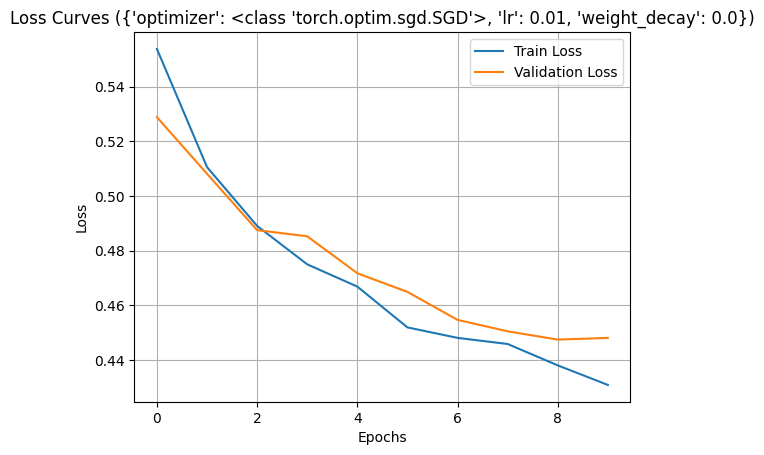


Testing Hyperparameters: {'optimizer': <class 'torch.optim.sgd.SGD'>, 'lr': 0.001, 'weight_decay': 0.0001}


Training Epoch 1/10: 100%|██████████| 313/313 [01:40<00:00,  3.10it/s]


Epoch [1/10] - Train Loss: 0.4310, Train Acc: 0.8530, Val Loss: 0.4472, Val Acc: 0.8490


Training Epoch 2/10: 100%|██████████| 313/313 [01:41<00:00,  3.09it/s]


Epoch [2/10] - Train Loss: 0.4278, Train Acc: 0.8555, Val Loss: 0.4442, Val Acc: 0.8503


Training Epoch 3/10: 100%|██████████| 313/313 [01:41<00:00,  3.09it/s]


Epoch [3/10] - Train Loss: 0.4287, Train Acc: 0.8542, Val Loss: 0.4486, Val Acc: 0.8433


Training Epoch 4/10: 100%|██████████| 313/313 [01:41<00:00,  3.10it/s]


Epoch [4/10] - Train Loss: 0.4296, Train Acc: 0.8524, Val Loss: 0.4493, Val Acc: 0.8451


Training Epoch 5/10: 100%|██████████| 313/313 [01:40<00:00,  3.10it/s]


Epoch [5/10] - Train Loss: 0.4253, Train Acc: 0.8564, Val Loss: 0.4475, Val Acc: 0.8469


Training Epoch 6/10: 100%|██████████| 313/313 [01:36<00:00,  3.24it/s]


Epoch [6/10] - Train Loss: 0.4266, Train Acc: 0.8561, Val Loss: 0.4497, Val Acc: 0.8454


Training Epoch 7/10: 100%|██████████| 313/313 [01:37<00:00,  3.21it/s]


Epoch [7/10] - Train Loss: 0.4266, Train Acc: 0.8551, Val Loss: 0.4382, Val Acc: 0.8504


Training Epoch 8/10: 100%|██████████| 313/313 [01:36<00:00,  3.25it/s]


Epoch [8/10] - Train Loss: 0.4277, Train Acc: 0.8546, Val Loss: 0.4407, Val Acc: 0.8497


Training Epoch 9/10: 100%|██████████| 313/313 [01:41<00:00,  3.09it/s]


Epoch [9/10] - Train Loss: 0.4260, Train Acc: 0.8555, Val Loss: 0.4446, Val Acc: 0.8483


Training Epoch 10/10: 100%|██████████| 313/313 [01:40<00:00,  3.11it/s]


Epoch [10/10] - Train Loss: 0.4265, Train Acc: 0.8565, Val Loss: 0.4466, Val Acc: 0.8478


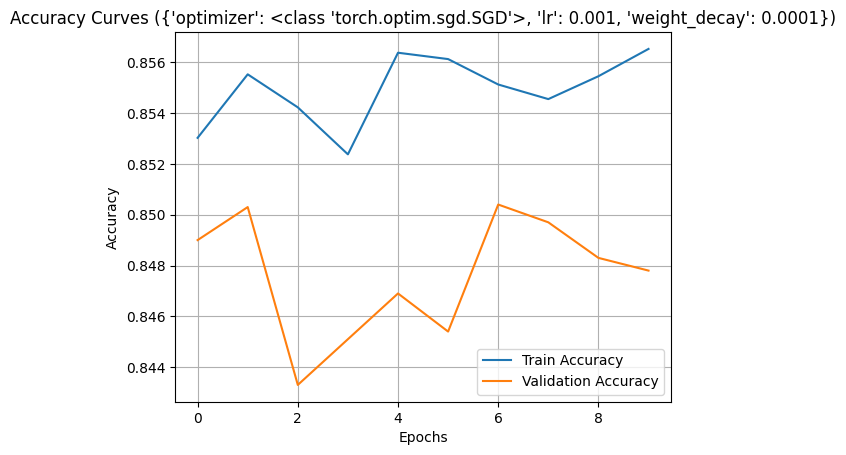

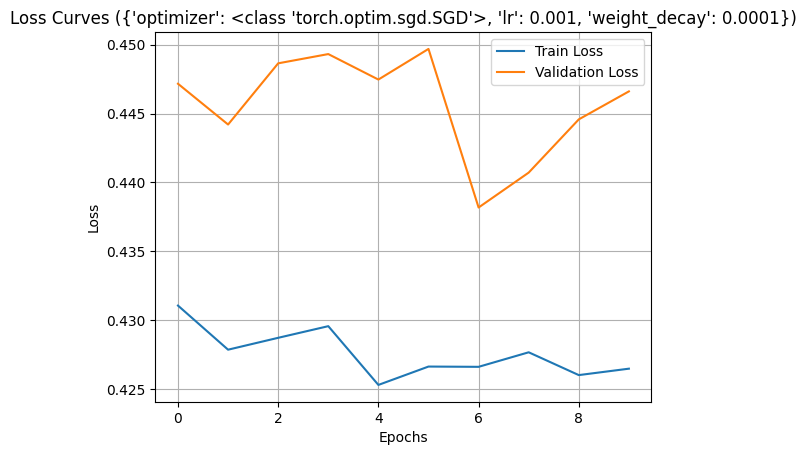


Retraining EfficientNetB0 with best parameters on full training data...


Training Epoch 1/10: 100%|██████████| 391/391 [02:02<00:00,  3.19it/s]


Epoch [1/10] - Train Loss: 0.4102, Train Acc: 0.8622, Val Loss: 0.3815, Val Acc: 0.8746


Training Epoch 2/10: 100%|██████████| 391/391 [02:06<00:00,  3.08it/s]


Epoch [2/10] - Train Loss: 0.3727, Train Acc: 0.8729, Val Loss: 0.3498, Val Acc: 0.8808


Training Epoch 3/10: 100%|██████████| 391/391 [02:06<00:00,  3.09it/s]


Epoch [3/10] - Train Loss: 0.3483, Train Acc: 0.8824, Val Loss: 0.3206, Val Acc: 0.8932


Training Epoch 4/10: 100%|██████████| 391/391 [02:07<00:00,  3.07it/s]


Epoch [4/10] - Train Loss: 0.3320, Train Acc: 0.8865, Val Loss: 0.3020, Val Acc: 0.8968


Training Epoch 5/10: 100%|██████████| 391/391 [02:07<00:00,  3.07it/s]


Epoch [5/10] - Train Loss: 0.3142, Train Acc: 0.8921, Val Loss: 0.2960, Val Acc: 0.8955


Training Epoch 6/10: 100%|██████████| 391/391 [02:07<00:00,  3.07it/s]


Epoch [6/10] - Train Loss: 0.2977, Train Acc: 0.8984, Val Loss: 0.2785, Val Acc: 0.9079


Training Epoch 7/10: 100%|██████████| 391/391 [02:07<00:00,  3.06it/s]


Epoch [7/10] - Train Loss: 0.2891, Train Acc: 0.9009, Val Loss: 0.2585, Val Acc: 0.9119


Training Epoch 8/10: 100%|██████████| 391/391 [02:07<00:00,  3.06it/s]


Epoch [8/10] - Train Loss: 0.2766, Train Acc: 0.9050, Val Loss: 0.2487, Val Acc: 0.9173


Training Epoch 9/10: 100%|██████████| 391/391 [02:07<00:00,  3.06it/s]


Epoch [9/10] - Train Loss: 0.2670, Train Acc: 0.9090, Val Loss: 0.2388, Val Acc: 0.9186


Training Epoch 10/10: 100%|██████████| 391/391 [02:08<00:00,  3.05it/s]


Epoch [10/10] - Train Loss: 0.2552, Train Acc: 0.9126, Val Loss: 0.2300, Val Acc: 0.9222
Highest Validation Accuracy for EfficientNetB0: 92.22%
Highest Testing Accuracy for EfficientNetB0: 86.17%

Comparison of Models:
            Model  Highest Validation Accuracy (%)  Test Accuracy
0       CustomCNN                            68.53          73.74
1        ResNet18                            89.26          82.17
2     MobileNetV2                            87.29          83.33
3  EfficientNetB0                            92.22          86.17


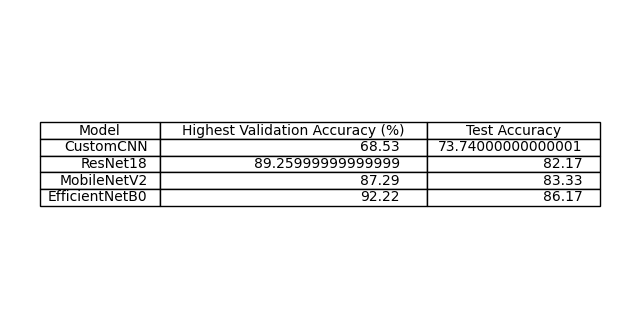

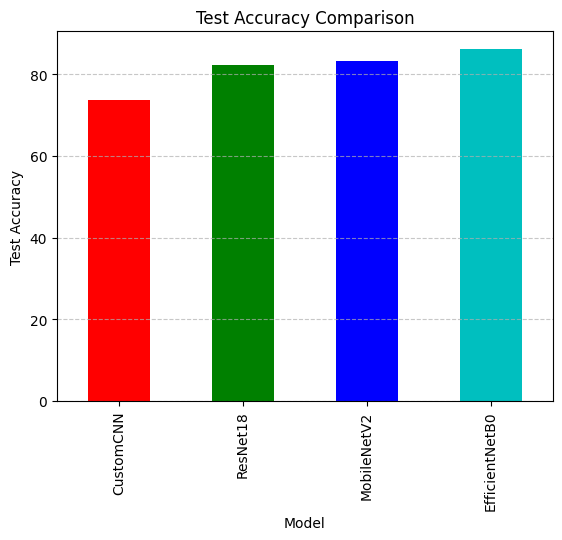

In [4]:
# Training function with real-time monitoring
def train_model(model, train_loader, val_loader, optimizer, num_epochs=10):
    model.to(device)
    best_val_acc = 0
    train_accs, val_accs, train_losses, val_losses = [], [], [], []

    for epoch in range(num_epochs):
        model.train()
        train_loss, train_correct, train_total = 0, 0, 0
        for data, target in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}"):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = nn.CrossEntropyLoss()(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_correct += (output.argmax(1) == target).sum().item()
            train_total += target.size(0)

        train_acc = train_correct / train_total
        train_accs.append(train_acc)
        train_losses.append(train_loss / len(train_loader))

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                val_loss += nn.CrossEntropyLoss()(output, target).item()
                val_correct += (output.argmax(1) == target).sum().item()
                val_total += target.size(0)

        val_acc = val_correct / val_total
        val_accs.append(val_acc)
        val_losses.append(val_loss / len(val_loader))

        # Printing loss and accuracy for the epoch
        print(
            f"Epoch [{epoch+1}/{num_epochs}] - "
            f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accs[-1]:.4f}, "
            f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accs[-1]:.4f}"
        )

        # Saving the best model based on validation accuracy
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), f"models/best_model_{model.__class__.__name__}.pth")

    return train_accs, val_accs, train_losses, val_losses

# Hyperparameter tuning for 10 epochs with visualization of loss and accuracy curves
def tune_hyperparameters(model, train_loader, val_loader, hyperparam_grid, num_epochs=10):
    best_val_acc = 0
    best_hyperparams = None

    # Ensure model is on the correct device
    model.to(device)

    for params in hyperparam_grid:
        print(f"\nTesting Hyperparameters: {params}")
        optimizer = params['optimizer'](model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])
        train_accs, val_accs, train_losses, val_losses = train_model(model, train_loader, val_loader, optimizer, num_epochs)

        # Plot accuracy and loss curves for each combination
        plt.figure()
        plt.plot(train_accs, label="Train Accuracy")
        plt.plot(val_accs, label="Validation Accuracy")
        plt.title(f"Accuracy Curves ({params})")
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.grid()
        plt.show()

        plt.figure()
        plt.plot(train_losses, label="Train Loss")
        plt.plot(val_losses, label="Validation Loss")
        plt.title(f"Loss Curves ({params})")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid()
        plt.show()

        # Check if current hyperparameters give the best validation accuracy
        if max(val_accs) > best_val_acc:
            best_val_acc = max(val_accs)
            best_hyperparams = params
            torch.save(model.state_dict(), f"models/best_tuned_{model.__class__.__name__}.pth")

    return best_hyperparams, best_val_acc



# Plotting results
def plot_results(results, title):
    df = pd.DataFrame(results)
    df.plot(kind="bar", x="Model", y="Test Accuracy", color=['r', 'g', 'b', 'c'], legend=False)
    plt.title(title)
    plt.ylabel("Test Accuracy")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Defining hyperparameter grids
hyperparam_grid_adam = [
    {'optimizer': optim.Adam, 'lr': 0.001, 'weight_decay': 0.0},
    {'optimizer': optim.Adam, 'lr': 0.01, 'weight_decay': 0.0001},
]

hyperparam_grid_sgd = [
    {'optimizer': optim.SGD, 'lr': 0.01, 'weight_decay': 0.0},
    {'optimizer': optim.SGD, 'lr': 0.001, 'weight_decay': 0.0001},
]

# Models list
models_list = [
    (CustomCNN(), train_loader_64, val_loader_64, test_loader_64, "CustomCNN"),
    (resnet18, train_loader_224, val_loader_224, test_loader_224, "ResNet18"),
    (mobilenet, train_loader_224, val_loader_224, test_loader_224, "MobileNetV2"),
    (efficientnet, train_loader_224, val_loader_224, test_loader_224, "EfficientNetB0"),
]

# Main loop for training, tuning, and evaluation
results = []
for model, train_loader, val_loader, test_loader, model_name in models_list:
    print(f"\nStarting tuning for {model_name}")
    hyperparam_grid = hyperparam_grid_adam + hyperparam_grid_sgd
    best_hyperparams, best_val_acc = tune_hyperparameters(model, train_loader, val_loader, hyperparam_grid)

    print(f"\nRetraining {model_name} with best parameters on full training data...")
    combined_train_set = ConcatDataset([train_loader.dataset, val_loader.dataset])
    combined_train_loader = DataLoader(combined_train_set, batch_size=batch_size, shuffle=True)
    optimizer = best_hyperparams['optimizer'](model.parameters(), lr=best_hyperparams['lr'], weight_decay=best_hyperparams['weight_decay'])
    train_accs, val_accs, train_losses, val_losses = train_model(model, combined_train_loader, val_loader, optimizer)

    # Evaluating on test set
    model.load_state_dict(torch.load(f"models/best_tuned_{model.__class__.__name__}.pth"))
    model.eval()
    test_correct, test_total = 0, 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_correct += (output.argmax(1) == target).sum().item()
            test_total += target.size(0)
    test_accuracy = test_correct / test_total

    # Storing results
    highest_val_acc = max(val_accs) * 100
    test_accuracy_percentage = test_accuracy * 100
    print(f"Highest Validation Accuracy for {model_name}: {highest_val_acc:.2f}%")
    print(f"Highest Testing Accuracy for {model_name}: {test_accuracy_percentage:.2f}%")
    results.append({
        'Model': model_name,
        'Highest Validation Accuracy (%)': highest_val_acc,
        'Test Accuracy': test_accuracy_percentage
    })

# Creating and display the table
results_df = pd.DataFrame(results)
print("\nComparison of Models:")
print(results_df)

# Displaying the table using matplotlib for a visual table
fig, ax = plt.subplots(figsize=(8, 4))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=results_df.values, colLabels=results_df.columns, loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width(col=list(range(len(results_df.columns))))
plt.show()

# Final results visualization (bar chart)
plot_results(results, "Test Accuracy Comparison")
